In [117]:
%%writefile helpers.py

from typing import Callable, List, Tuple
import numpy as np
import matplotlib.pyplot as plt


def get_color(seed: int) -> np.array:
  np.random.seed(seed * 142321)
  return np.random.uniform(0.2, 0.8, size=3)


def execute_simulation(alpha, n_windows, iterations: int, experiment: Callable[[float, int], np.array]) -> np.array:
  sum = np.zeros(n_windows)
  for it in range(iterations):
    sum += np.sort(experiment(alpha, n_windows))
  return sum / iterations


def build_charts(
    experiments: List[Tuple[str, Callable[[float, int], np.array], str]], # list of pairs (name, exp, style, multiple)
    opt_n_windows: List[int],
    opt_alpha: List[float],
    iterations: int,
):
  for n_windows in opt_n_windows:
    _, win_plot = plt.subplots()
    legend = []
    for i_alpha, alpha in enumerate(opt_alpha):
      for exp_name, exp, style, multiple in experiments:
        win_plot.plot(
            range(0, n_windows),
            execute_simulation(
                alpha,
                n_windows,
                iterations if multiple else 1, exp
            ),
            c=get_color(i_alpha),
            linestyle=style
        )
        legend.append('{}, a={}'.format(exp_name, alpha))
    win_plot.legend(legend)
    win_plot.title.set_text('Windows = {}'.format(n_windows))


Writing helpers.py


# (a) Не более двух человек на окошко

## Ход эксперимента

Нужно всего лишь узнать сколько ждали `n` "вторых" людей. Для этого сгенерируем выборку размера `n_windows` случайных занчений с экспоненциальным распределением, всё.
Данный эксперимент проведем `iterations` раз (я проводил 1000 раз) и вычислим среднее. Также с практики мы знаем как можно посчитать теоретическое значение среднего, сравним его с тем, что получим на практике.

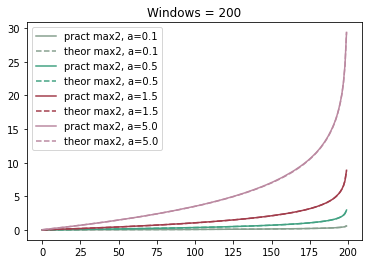

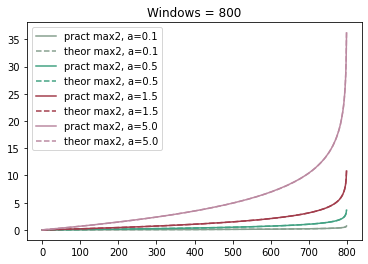

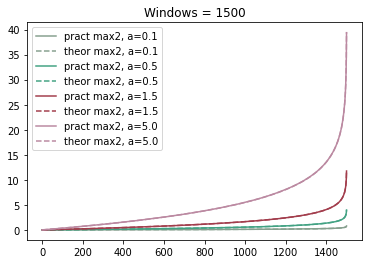

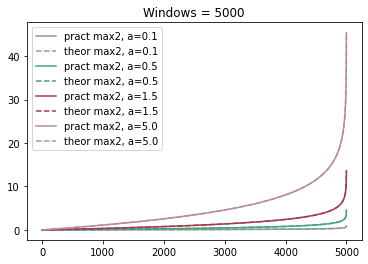

In [115]:
from helpers import build_charts

def experimental_max2(alpha: float, n_windows: int) -> np.array:
  return np.sort(np.random.exponential(alpha, n_windows))


def theoretical_max2(alpha: float, n_windows: int) -> np.array:
  theor = np.zeros(n_windows)
  theor[0] = 1.0 / n_windows
  for i in range(1, n_windows):
    theor[i] = theor[i - 1] + 1.0 / (n_windows - i)
  return theor * alpha



opt_n_windows = [200, 800, 1500, 5000]
opt_alpha = [0.1, 0.5, 1.5, 5.0]
iterations = 1000

build_charts(
    experiments=[
     ('pract max2', experimental_max2, 'solid', True),
     ('theor max2', theoretical_max2, 'dashed', False),
    ],
    opt_n_windows=[200, 800, 1500, 5000],
    opt_alpha=[0.1, 0.5, 1.5, 5.0],
    iterations=1000
)

## Результат

Получили, что результат, полученный в теории примерно совпадает с полученным в ходе эксперимента (видно, что пунктирные и целые линии везде совпадают).

# (b) Много людей на одно окошко

## Ход эксперимента

Будем моделировать ситуацию следующим образом. Будем поддерживать набор времен приёмов, в начале которго будет лежать минимальное время. Далее каждый раз будем доставать минимальное значение - это будет значить, что очередной человек подошёл к какому-то окошку. И если люди ещё есть, то добавим в набор следующего ожидающего человека: время его приёма будет текущее время плюс случайная величина.

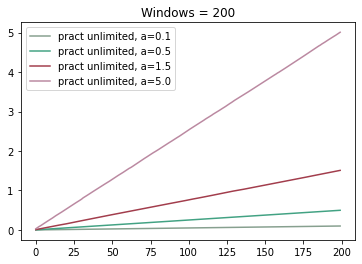

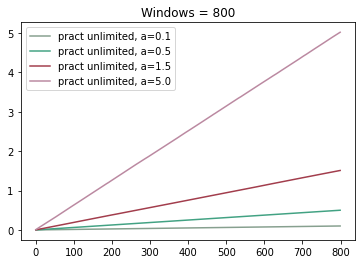

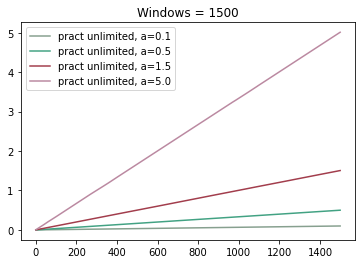

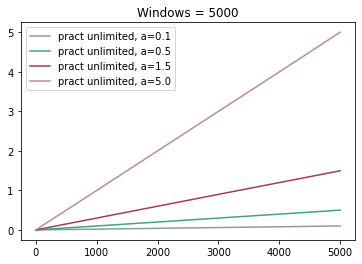

In [118]:
from helpers import build_charts

import heapq


def experimental_unlimited(alpha: float, n: int) -> np.array:
  gen = lambda: np.random.exponential(alpha, 1)[0]
  waiting = [gen() for _ in range(n)]
  persons_left = n
  heapq.heapify(waiting)
  t = 0.0
  finished = []
  while (persons_left != 0):
    lucky = heapq.heappop(waiting)
    finished.append(lucky)
    heapq.heappush(waiting, lucky + gen())
    persons_left -= 1
  return finished


build_charts(
    experiments=[('pract unlimited', experimental_unlimited, 'solid', True)],
    opt_n_windows=[200, 800, 1500, 5000],
    opt_alpha=[0.1, 0.5, 1.5, 5.0],
    iterations=200
)

## Результаты

Получились графики прямой пропорциональности с наклоном <i> alpha/n </i>